# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [2]:
import warnings
# warnings.filterwarnings('ignore')

In [50]:
import pandas as pd
import patsy
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Getting data

In [2]:
file_name = '../csvs/element_gameweek_features_v03.csv'

In [3]:
element_gameweek_df = pd.read_csv(file_name)

In [4]:
current_event = 20

In [5]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [6]:
element_gameweek_df.fillna(3, inplace=True)

In [7]:
element_gameweek_df.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_against_opposition_team_element_type,rolling_avg_total_points_home,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground
0,cech,1,1,1,1,13,1,1,50,1,...,3.0,3.0,3.0,3.0,3.0,3,3.000000,3.000000,3.000000,3.0
1,cech,1,2,14,1,6,0,1,50,0,...,3.0,3.0,3.0,3.0,3.0,3,0.681818,3.000000,3.000000,3.0
2,cech,1,3,21,1,19,1,1,50,0,...,8.0,3.0,3.0,3.0,3.0,3,3.750000,0.000000,3.000000,3.0
3,cech,1,4,33,1,5,0,1,50,1,...,11.0,3.0,3.0,6.0,3.0,1,4.493304,0.000000,4.901786,3.0
4,cech,1,5,46,1,15,0,1,50,0,...,49.0,3.0,0.0,2.0,0.0,2,3.663651,5.929855,1.332237,0.0


In [8]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [9]:
last_train_event = 15

In [10]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [11]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Building model

In [12]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'rolling_avg_attempted_passes_element',
     'rolling_var_total_points_against_opposition_team',
     'rolling_var_total_points_own_team',
     'rolling_var_total_points_opposition_team',
     'rolling_var_total_points_element_type',
     'rolling_var_total_points_against_opposition_team_element_type',
     'expected_var_total_points_against_opposition_team',
     'expected_var_total_points_at_ground',
     'rolling_avg_total_points_home',
     'rolling_var_total_points_home',
     'rolling_avg_total_points_against_opposition_ground_element_type',
     'rolling_var_total_points_against_opposition_ground_element_type',
     'total_points'
 ]])

In [13]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + value + is_sunday + is_weekday + is_late + is_early + rolling_avg_total_points_element + rolling_var_total_points_element + rolling_max_total_points_element + rolling_avg_minutes_element_p3 + rolling_avg_bps_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolli

In [14]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [15]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [16]:
n_features = X.shape[1]

## Selecting features

In [51]:
estimator = DecisionTreeRegressor(min_samples_leaf=0.15)
selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector.fit(X, y.ravel())

Fitting estimator with 435 features.
Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
F

Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
F

Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
F

Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                      max_features=None, max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=0.15,
                                      min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      presort=False, random_state=None,
                                      splitter='best'),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [52]:
features = patsy.dmatrices(formula, element_gameweek_df, return_type='dataframe')[1].columns
selected_features = pd.Series(features)[selector.support_]
list(selected_features)

['value', 'expected_avg_total_points_against_opposition_team']

In [67]:
stark_X_sel = X[:,selector.support_]
stark_X_train_sel = X_train[:,selector.support_]
stark_X_test_sel = X_test[:,selector.support_]

In [68]:
lush_X_sel = X
lush_X_train_sel = X_train
lush_X_test_sel = X_test

## Tuning model

### GP tuner

#### Decision tree (lush)

In [158]:
lush_space = [
    Real(0.01, 0.06, 'uniform', name='min_samples_leaf'),
    Real(0.6, 0.7, 'uniform', name='max_features'),
]

In [159]:
lush_gp_model = DecisionTreeRegressor()

@use_named_args(lush_space)
def lush_objective(**params):
    lush_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lush_gp_model,
            lush_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [160]:
lush_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    lush_res_gp = gp_minimize(lush_objective, lush_space, n_calls=30, verbose=2)
    lush_res_gp_arr.append(lush_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0709
Function value obtained: 10.0575
Current minimum: 10.0575
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0525
Function value obtained: 10.2140
Current minimum: 10.0575
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0613
Function value obtained: 9.9483
Current minimum: 9.9483
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0468
Function value obtained: 9.6869
Current minimum: 9.6869
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0489
Function value obtained: 9.8742
Current minimum: 9.6869
Iterat

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.5718
Function value obtained: 10.0288
Current minimum: 9.7200
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.6562
Function value obtained: 9.6680
Current minimum: 9.6680
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5438
Function value obtained: 9.8137
Current minimum: 9.6680
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.5497
Function value obtained: 10.1437
Current minimum: 9.6680
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.6419
Function value obtained: 9.7308
Current minimum: 9.6680
Iteration No: 17 started. S

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.7832
Function value obtained: 9.7363
Current minimum: 9.5221
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.7340
Function value obtained: 9.8693
Current minimum: 9.5221
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.8218
Function value obtained: 9.9154
Current minimum: 9.5221
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.7381
Function value obtained: 9.8168
Current minimum: 9.5221
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.7516
Function value obtained: 10.3906
Current minimum: 9.5221
Iteration No: 28 started. Se

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7501
Function value obtained: 9.6920
Current minimum: 9.5737
Iteration No: 26 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.7912
Function value obtained: 9.8034
Current minimum: 9.5737
Iteration No: 27 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.7529
Function value obtained: 9.8041
Current minimum: 9.5737
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.7079
Function value obtained: 9.7752
Current minimum: 9.5737
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.7935
Function value obtained: 9.9337
Current minimum: 9.5737
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.7479
Function value obtained: 9.8101
Current minimum: 9.5737
minimisation iteration 5
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0526
Function value obtained: 9.7851
Current minimum: 9.7851
Iteration No: 2 st

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.6885
Function value obtained: 9.7767
Current minimum: 9.5039
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5261
Function value obtained: 9.9055
Current minimum: 9.5039
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4870
Function value obtained: 9.9202
Current minimum: 9.5039
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.5441
Function value obtained: 9.7013
Current minimum: 9.5039
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.5811
Function value obtained: 9.9817
Current minimum: 9.5039
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.5107
Function value obtained: 9.7552
Current minimum: 9.5039
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.7707
Function value obtained: 9.7353
Current minimum: 9.5039
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.7735
Function value obtained: 9.6217
Current minimum: 9.5039
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.7948
Function value obtained: 9.9204
Current minimum: 9.5039
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.6543
Function value obtained: 10.0400
Current minimum: 9.5039
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.7738
Function value obtained: 9.6606
Current minimum: 9.5039
Iteration No: 24 started. Se

In [161]:
for i in lush_res_gp_arr:
    print(i.fun)
print('\n')
for i in lush_res_gp_arr:
    print(i.x)

9.644829214574136
9.609732903940193
9.522096409787585
9.573744114030662
9.503924103418074


[0.05651389583819214, 0.6]
[0.04391291351012633, 0.7]
[0.022192119008698195, 0.6446727271693776]
[0.030678283035736796, 0.6919249978263097]
[0.04953003036061004, 0.6316218159150546]


#### Decision tree (stark)

In [83]:
stark_space = [
    Real(0.01, 0.05, 'uniform', name='min_samples_leaf')
]

In [84]:
stark_gp_model = DecisionTreeRegressor()

@use_named_args(stark_space)
def stark_objective(**params):
    stark_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            stark_gp_model,
            stark_X_sel, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [85]:
stark_res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    stark_res_gp = gp_minimize(stark_objective, stark_space, n_calls=30, verbose=2)
    stark_res_gp_arr.append(stark_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0066
Function value obtained: 9.6837
Current minimum: 9.6837
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0060
Function value obtained: 9.9418
Current minimum: 9.6837
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0061
Function value obtained: 10.0254
Current minimum: 9.6837
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0049
Function value obtained: 9.7032
Current minimum: 9.6837
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0052
Function value obtained: 9.6457
Current minimum: 9.6457
Iteration

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.4022
Function value obtained: 9.5616
Current minimum: 9.5616
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.3793
Function value obtained: 9.5616
Current minimum: 9.5616
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3596
Function value obtained: 9.6120
Current minimum: 9.5616
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4221
Function value obtained: 9.6519
Current minimum: 9.5616
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4563
Function value obtained: 9.5802
Current minimum: 9.5616
Iteration No: 17 started. Sea

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4694
Function value obtained: 9.5536
Current minimum: 9.5536
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5996
Function value obtained: 9.5536
Current minimum: 9.5536
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5548
Function value obtained: 9.5616
Current minimum: 9.5536
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.6993
Function value obtained: 9.5536
Current minimum: 9.5536
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.6905
Function value obtained: 9.7345
Current minimum: 9.5536
Iteration No: 28 started. Sea

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.3605
Function value obtained: 9.6519
Current minimum: 9.5690
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.3163
Function value obtained: 9.6215
Current minimum: 9.5690
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.3705
Function value obtained: 9.7163
Current minimum: 9.5690
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.5496
Function value obtained: 10.0896
Current minimum: 9.5690
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5311
Function value obtained: 9.5621
Current minimum: 9.5621
Iteration No: 15 started. Searching for

In [86]:
for i in stark_res_gp_arr:
    print(i.fun)
print('\n')
for i in stark_res_gp_arr:
    print(i.x)

9.553582115135343
9.553582115135343
9.553582115135343
9.553582115135343
9.553582115135343


[0.02758972847250904]
[0.02776540372720525]
[0.027452157878565198]
[0.02775740029288641]
[0.02751394576785486]


### Grid search

#### Decision tree (lush)

In [208]:
min_samples_leaf_lush = [0.064, 0.065, 0.066]
max_features_lush = [0.44, 0.45, 0.46]

parameters_lush = {
    'min_samples_leaf': min_samples_leaf_lush,
    'max_features': max_features_lush
}

In [209]:
gs_model_lush = GridSearchCV(
    DecisionTreeRegressor(random_state=0),
    parameters_lush,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_lush.fit(lush_X_sel, y.ravel())

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] max_features=0.44, min_samples_leaf=0.064 .......................
[CV] ........ max_features=0.44, min_samples_leaf=0.064, total=   0.0s
[CV] max_features=0.44, min_samples_leaf=0.065 .......................
[CV] ........ max_features=0.44, min_samples_leaf=0.065, total=   0.0s
[CV] max_features=0.44, min_samples_leaf=0.066 .......................
[CV] ........ max_features=0.44, min_samples_leaf=0.066, total=   0.0s
[CV] max_features=0.45, min_samples_leaf=0.064 .......................
[CV] ........ max_features=0.45, min_samples_leaf=0.064, total=   0.0s
[CV] max_features=0.45, min_samples_leaf=0.065 .......................
[CV] ........ max_features=0.45, min_samples_leaf=0.065, total=   0.0s
[CV] max_features=0.45, min_samples_leaf=0.066 .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........ max_features=0.45, min_samples_leaf=0.066, total=   0.0s
[CV] max_features=0.46, min_samples_leaf=0.064 .......................
[CV] ........ max_features=0.46, min_samples_leaf=0.064, total=   0.0s
[CV] max_features=0.46, min_samples_leaf=0.065 .......................
[CV] ........ max_features=0.46, min_samples_leaf=0.065, total=   0.0s
[CV] max_features=0.46, min_samples_leaf=0.066 .......................
[CV] ........ max_features=0.46, min_samples_leaf=0.066, total=   0.0s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=0,
                                             splitter='best'),
             iid='warn', n_jobs=1,
             param_grid={'max_features': [0.44, 0.45, 0.46],
                         'min_samples_leaf': [0.064, 0.065, 0.066]},
             pre_dispatch='2*n_jobs',

In [210]:
gs_model_df_lush = pd.DataFrame(gs_model_lush.cv_results_)[[
    'param_min_samples_leaf', 'param_max_features',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_df_lush

,param_min_samples_leaf,param_max_features,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,0.064,0.44,-2.262601,-9.934812
1,0.065,0.44,-2.235896,-9.812995
2,0.066,0.44,-2.264309,-9.928947
3,0.064,0.45,-2.181027,-9.554404
4,0.065,0.45,-2.181027,-9.554404
5,0.066,0.45,-2.181027,-9.554404
6,0.064,0.46,-2.184141,-9.612168
7,0.065,0.46,-2.184141,-9.612168
8,0.066,0.46,-2.184141,-9.612168


In [211]:
gs_model_df_lush[
    gs_model_df_lush['split0_test_neg_mean_squared_error'] == \
    gs_model_df_lush['split0_test_neg_mean_squared_error'].max()]

,param_min_samples_leaf,param_max_features,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
3,0.064,0.45,-2.181027,-9.554404
4,0.065,0.45,-2.181027,-9.554404
5,0.066,0.45,-2.181027,-9.554404


#### Decision tree (stark)

In [104]:
min_samples_leaf_stark = [0.026, 0.027, 0.028]

parameters_stark = {
    'min_samples_leaf': min_samples_leaf_stark
}

In [105]:
gs_model_stark = GridSearchCV(
    DecisionTreeRegressor(),
    parameters_stark,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model_stark.fit(stark_X_sel, y.ravel())

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] min_samples_leaf=0.026 ..........................................
[CV] ........................... min_samples_leaf=0.026, total=   0.0s
[CV] min_samples_leaf=0.027 ..........................................
[CV] ........................... min_samples_leaf=0.027, total=   0.0s
[CV] min_samples_leaf=0.028 ..........................................
[CV] ........................... min_samples_leaf=0.028, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=1,
             param_grid={'min_samples_leaf': [0.026, 0.027, 0.028]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scori

In [106]:
gs_model_df_stark = pd.DataFrame(gs_model_stark.cv_results_)[[
    'param_min_samples_leaf',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_df_stark

,param_min_samples_leaf,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,0.026,-2.223950,-9.580231
1,0.027,-2.221858,-9.568991
2,0.028,-2.226590,-9.611255


In [103]:
gs_model_df_stark[
    gs_model_df_stark['split0_test_neg_mean_squared_error'] == \
    gs_model_df_stark['split0_test_neg_mean_squared_error'].max()]

,param_min_samples_leaf,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
2,0.027,-2.221858,-9.568991


# Evaluating model

## Decision tree (lush)

In [212]:
lush_model = DecisionTreeRegressor(random_state=0, min_samples_leaf=0.065, max_features=0.45)
lush_model.fit(lush_X_train_sel, y_train.ravel())

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=0.45,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.065,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [213]:
# get predictions for test set
lush_y_pred = lush_model.predict(lush_X_test_sel).flatten()

# calculate cross entropy loss for test set
lush_test_loss = (
    mean_absolute_error(y_test, lush_y_pred),
    mean_squared_error(y_test, lush_y_pred),
    r2_score(y_test, lush_y_pred)
)
lush_test_loss

(2.1810268776697757, 9.554404344574284, 0.0819094517697988)

In [214]:
pd.Series(lush_y_pred).describe()

count    948.000000
mean       2.695557
std        0.943546
min        1.276923
25%        2.118421
50%        2.463415
75%        3.171123
max        4.800905
dtype: float64

In [215]:
# refit model on all data
lush_model_full = DecisionTreeRegressor(random_state=0, min_samples_leaf=0.027)
lush_model_full.fit(lush_X_sel, y.ravel())

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.027,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [216]:
# get predictions for whole set
lush_y_pred_full = lush_model_full.predict(lush_X_sel).flatten()

# calculate cross entropy loss for test set
lush_test_loss_full = (
    mean_absolute_error(y, lush_y_pred_full),
    mean_squared_error(y, lush_y_pred_full),
    r2_score(y, lush_y_pred_full)
)
lush_test_loss_full

(2.057949736688443, 8.132607674416846, 0.1500695908632712)

In [217]:
pd.Series(lush_y_pred_full).describe()

count    3644.000000
mean        2.869374
std         1.198476
min         0.876190
25%         2.103659
50%         2.652439
75%         3.640845
max         6.134615
dtype: float64

In [218]:
abs(pd.Series(y.ravel()) - pd.Series(lush_y_pred_full)).describe()

count    3644.000000
mean        2.057950
std         1.974467
min         0.000000
25%         0.666667
50%         1.534653
75%         2.666667
max        14.865385
dtype: float64

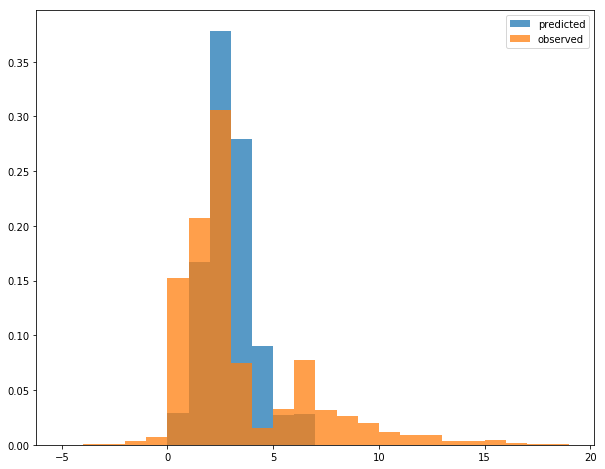

In [219]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

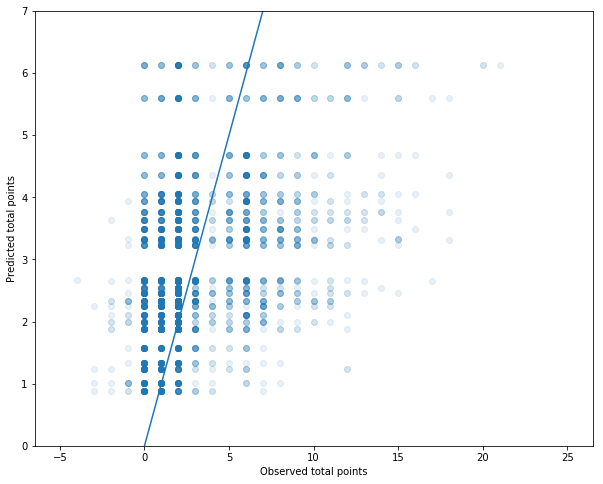

In [225]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(lush_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

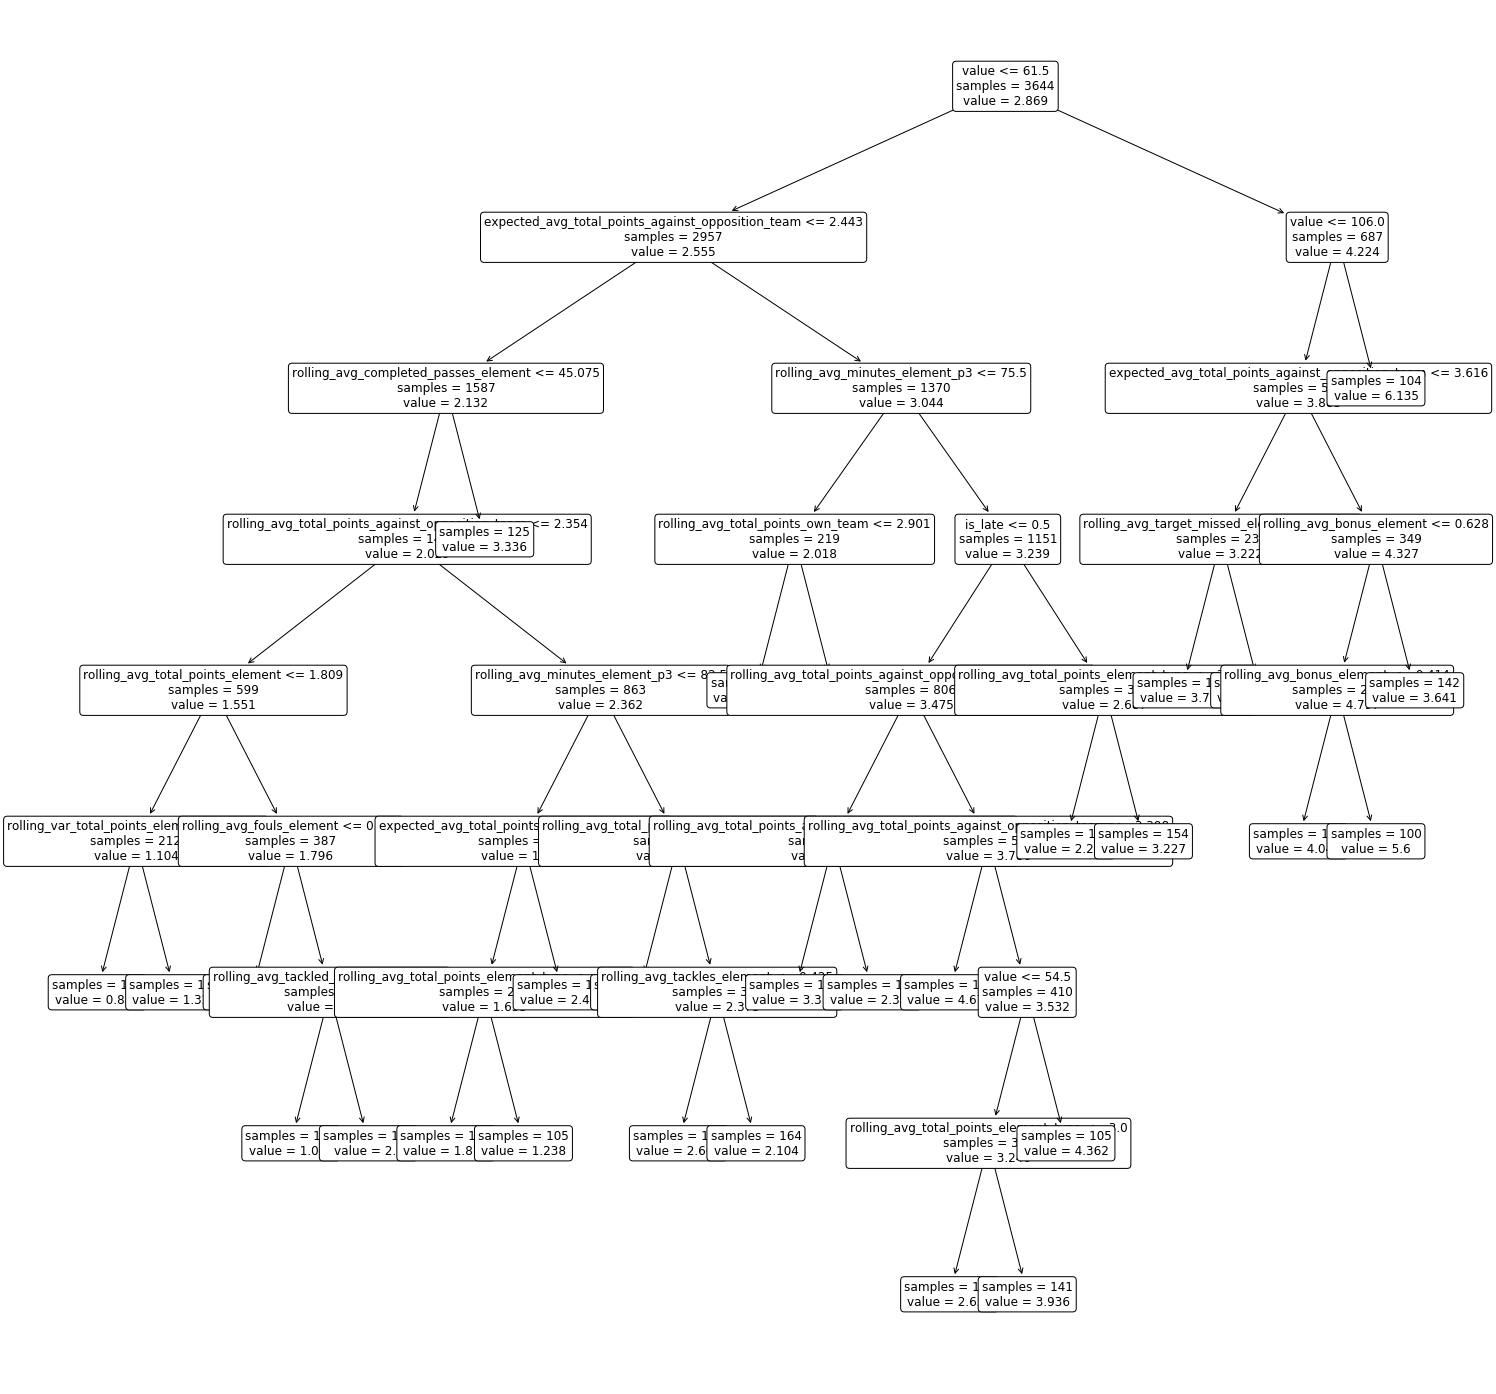

In [257]:
plt.figure(figsize=(25, 25))
plot_tree(
    lush_model_full,
    impurity=False,
    fontsize=12,
    rounded=True,
    feature_names=lush_X_sel.design_info.column_names)
plt.show()

## Decision tree (stark)

In [119]:
stark_model = DecisionTreeRegressor(random_state=0, min_samples_leaf=0.027)
stark_model.fit(stark_X_train_sel, y_train.ravel())

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.027,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [120]:
# get predictions for test set
stark_y_pred = stark_model.predict(stark_X_test_sel).flatten()

# calculate cross entropy loss for test set
stark_test_loss = (
    mean_absolute_error(y_test, stark_y_pred),
    mean_squared_error(y_test, stark_y_pred),
    r2_score(y_test, stark_y_pred)
)
stark_test_loss

(2.2218580634004352, 9.568990731856482, 0.08050783385478799)

In [121]:
pd.Series(stark_y_pred).describe()

count    948.000000
mean       2.772266
std        0.988079
min        1.337931
25%        2.161905
50%        2.496403
75%        3.317460
max        5.883117
dtype: float64

In [122]:
# refit model on all data
stark_model_full = DecisionTreeRegressor(random_state=0, min_samples_leaf=0.027)
stark_model_full.fit(stark_X_sel, y.ravel())

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.027,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [123]:
# get predictions for whole set
stark_y_pred_full = stark_model_full.predict(stark_X_sel).flatten()

# calculate cross entropy loss for test set
stark_test_loss_full = (
    mean_absolute_error(y, stark_y_pred_full),
    mean_squared_error(y, stark_y_pred_full),
    r2_score(y, stark_y_pred_full)
)
stark_test_loss_full

(2.142122107138868, 8.57277375064659, 0.10406828989864769)

In [124]:
pd.Series(stark_y_pred_full).describe()

count    3644.000000
mean        2.869374
std         0.998026
min         1.313131
25%         2.205357
50%         2.683761
75%         3.187135
max         6.134615
dtype: float64

In [125]:
abs(pd.Series(y.ravel()) - pd.Series(stark_y_pred_full)).describe()

count    3644.000000
mean        2.142122
std         1.996292
min         0.016260
25%         0.736364
50%         1.683761
75%         2.852941
max        15.137615
dtype: float64

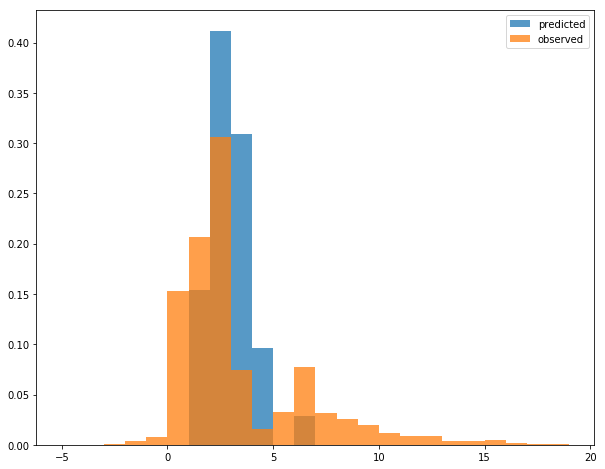

In [126]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_y_pred_full), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

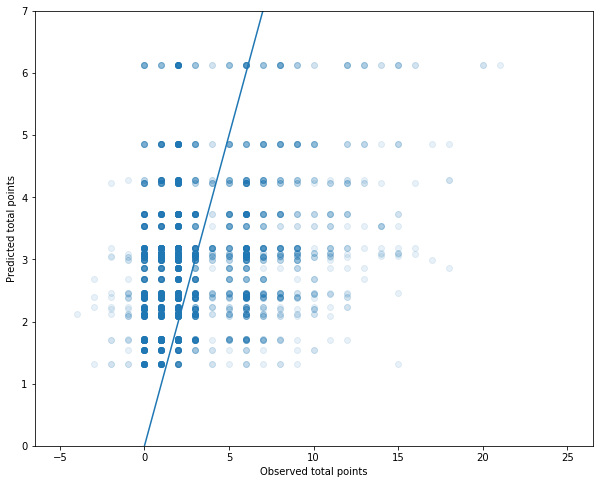

In [127]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(stark_y_pred_full), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

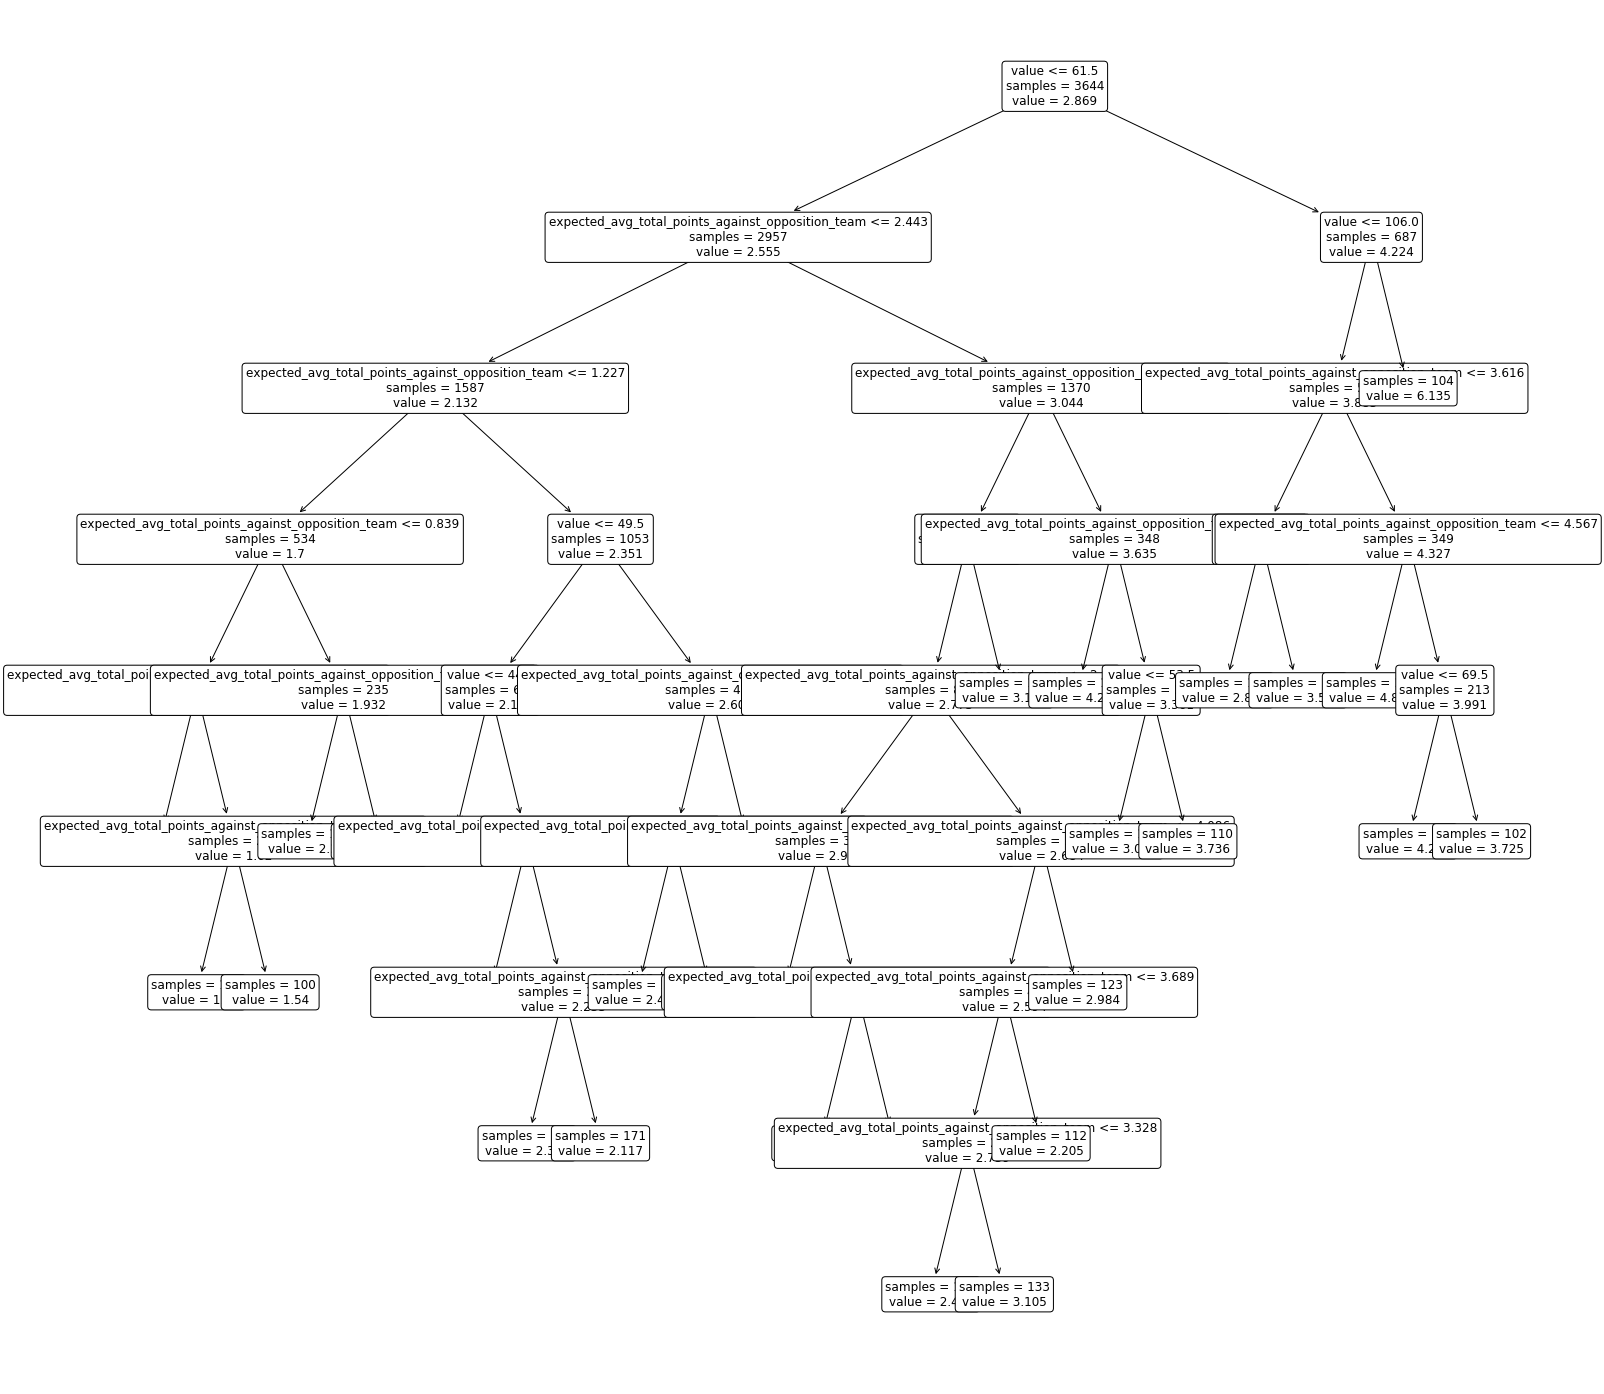

In [265]:
plt.figure(figsize=(25, 25))
plot_tree(
    stark_model_full,
    impurity=False,
    fontsize=12,
    rounded=True,
    feature_names=selected_features.values)
plt.show()

## Summary

In [221]:
pd.DataFrame([
    ('Decision tree (lush)', lush_test_loss[0], lush_test_loss[1], lush_test_loss[2]),
    ('Decision tree (stark)', stark_test_loss[0], stark_test_loss[1], stark_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Decision tree (lush),2.181027,9.554404,0.081909
1,Decision tree (stark),2.221858,9.568991,0.080508


In [223]:
pd.DataFrame([
    ('Decision tree (lush)', lush_test_loss_full[0], lush_test_loss_full[1], lush_test_loss_full[2]),
    ('Decision tree (stark)', stark_test_loss_full[0], stark_test_loss_full[1], stark_test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Decision tree (lush),2.057950,8.132608,0.150070
1,Decision tree (stark),2.142122,8.572774,0.104068
